In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split

from pyEDM import *

from libs.funcs import *

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [8]:
# read in NA ECO_LEVEL 3 raster files
gdf = gpd.read_file('../data/NA_CEC_Eco_Level3/')

wus_eco = gdf[gdf['NA_L3NAME'].isin(eco_regions)]
cascades_shp = gdf[gdf['NA_L3NAME'] == 'Cascades']

In [11]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)
cascades_shp = cascades_shp.to_crs(crs_proj4)

In [22]:
cascades_shp.crs

<Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
winds = xr.open_dataset('./data/ERA/ERA5_wind.nc')
winds['date'] = pd.to_datetime(winds.date.astype('str'), format='%Y%m%d')
winds = winds.rename({'date':'time'})

winds = winds.sel(time=slice('1960-10-01','2019-09-01'))

In [14]:
winds_c = winds.coarsen(longitude=8, latitude=8, boundary='pad').mean()

In [15]:
winds_c

<xarray.Dataset>
Dimensions:         (time: 708, pressure_level: 1, latitude: 41, longitude: 51)
Coordinates:
  * time            (time) datetime64[ns] 1960-10-01 1960-11-01 ... 2019-09-01
  * pressure_level  (pressure_level) float64 850.0
  * latitude        (latitude) float64 59.12 57.12 55.12 ... -16.88 -18.88 -20.0
  * longitude       (longitude) float64 -179.1 -177.1 -175.1 ... -81.12 -80.0
Data variables:
    number          int64 0
    expver          (time) object '0001' '0001' '0001' ... '0001' '0001' '0001'
    u               (time, pressure_level, latitude, longitude) float32 3.446...
    v               (time, pressure_level, latitude, longitude) float32 -1.63...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-16T08:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
u_anoms = (winds.u.groupby('time.month') - winds.u.groupby('time.month').mean()).drop('month')
v_anoms = (winds.v.groupby('time.month') - winds.v.groupby('time.month').mean()).drop('month')

In [17]:
w_anoms = (winds.groupby('time.month') - winds.groupby('time.month').mean()).drop('month')


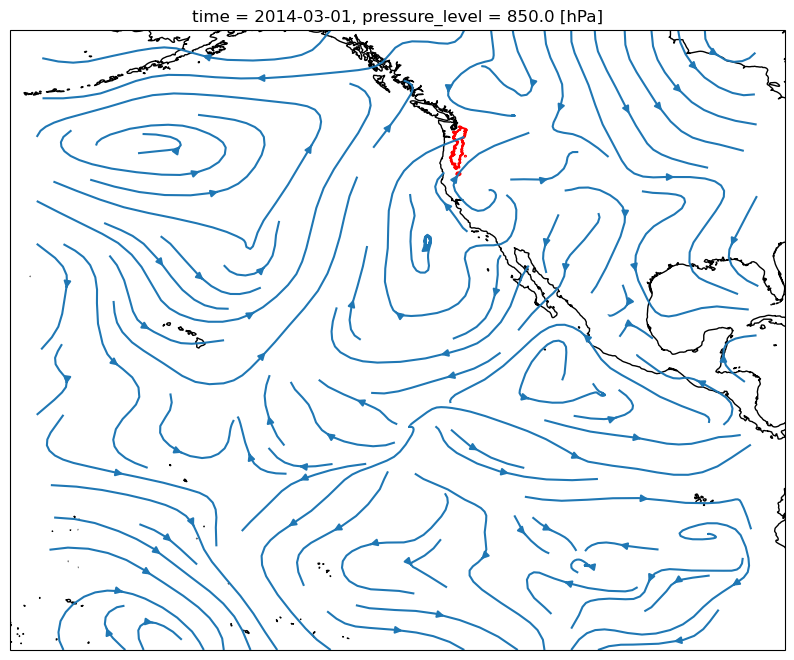

In [25]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cascades_shp.boundary.plot(ax=ax, color='r', transform=ccrs.PlateCarree())

w_anoms.isel(pressure_level=0).sel(time='2014-03-01').plot.streamplot(ax=ax,
                                x='longitude',
                                y='latitude',
                                u='u',
                                v='v', transform=ccrs.PlateCarree())

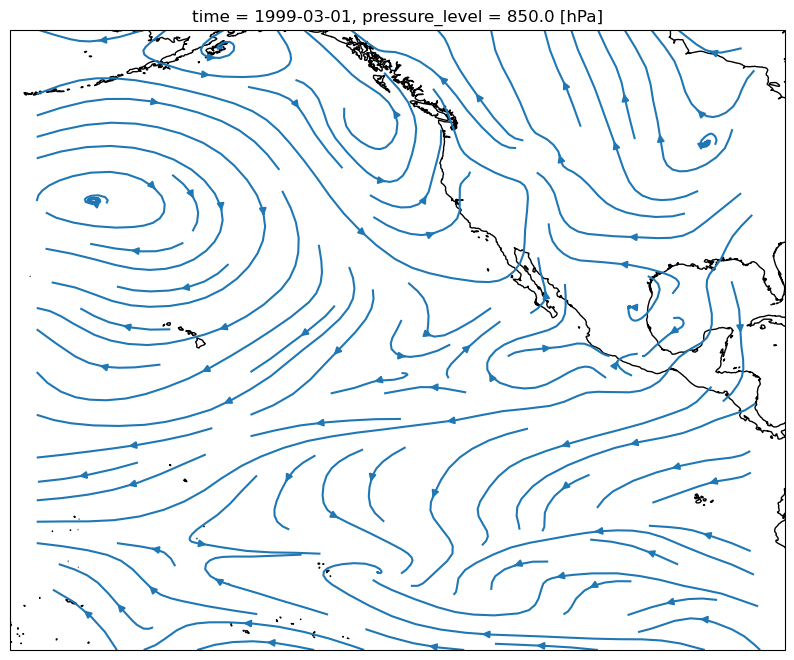

In [23]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

w_anoms.isel(pressure_level=0).sel(time='1999-03-01').plot.streamplot(ax=ax,
                                x='longitude',
                                y='latitude',
                                u='u',
                                v='v', transform=ccrs.PlateCarree())

In [100]:
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
# ax.coastlines(resolution='50m', color='black', linewidth=1)

# ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

# winds.isel(time=-1, pressure_level=0).plot.streamplot(ax=ax,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())

In [26]:
ssts = xr.open_dataset('./data/SST_anoms.nc')

In [27]:
hsnow_mar_sst = ssts.sst.sel(time=((ssts['time'].dt.month==3) &
                                (ssts['time'].dt.year.isin([1982, 1985, 1989, 1997, 1999, 2006, 2008, 2011]))))

hsnow_jan_sst = ssts.sst.sel(time=((ssts['time'].dt.month==1) &
                                (ssts['time'].dt.year.isin([1982, 1985, 1989, 1997, 1999, 2006, 2008, 2011]))))

hsnow_oct_sst = ssts.sst.sel(time=((ssts['time'].dt.month==10) &
                                (ssts['time'].dt.year.isin([1981, 1984, 1988, 1996, 1998, 2005, 2007, 2010]))))

In [28]:
lsnow_mar_sst = ssts.sst.sel(time=((ssts['time'].dt.month==3) &
                                (ssts['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))))

lsnow_jan_sst = ssts.sst.sel(time=((ssts['time'].dt.month==1) &
                                (ssts['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))))

lsnow_oct_sst = ssts.sst.sel(time=((ssts['time'].dt.month==10) &
                                (ssts['time'].dt.year.isin([1980, 1991, 2000, 2004, 2014]))))

In [29]:
# ssts.sst.isel(time=-1).plot.contourf()

In [30]:
# importing ERA5 data

In [31]:
slps = xr.open_dataset('./data/ERA/ERA5_mslp_pacific.nc', decode_times=True)

In [32]:
slps['date'] = pd.to_datetime(slps.date.astype('str'), format='%Y%m%d')

In [33]:
slps = slps.rename({'date':'time'})

In [34]:
slps

<xarray.Dataset>
Dimensions:    (time: 960, latitude: 321, longitude: 641)
Coordinates:
    number     int64 ...
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2019-12-01
  * latitude   (latitude) float64 60.0 59.75 59.5 59.25 ... -19.5 -19.75 -20.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 279.5 279.8 280.0
    expver     (time) object ...
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-19T17:37 GRIB to CDM+CF via cfgrib-0.9.1...

In [35]:
slps = slps.sel(time=slice('1960-10-01','2019-09-01'))

In [36]:
slps['msl'] = slps['msl']/100

In [37]:
# # https://stackoverflow.com/a/74489930
# slp_anoms = xr.apply_ufunc(
#     lambda x, mean: x - mean, 
#     slps.msl.groupby('time.month'),
#     slps.msl.groupby('time.month').mean()
# ).drop('month')

In [38]:
slp_anoms = (slps.msl.groupby('time.month') - slps.msl.groupby('time.month').mean()).drop('month')

In [39]:
slp_anoms['month'] = slp_anoms['time.month']

In [40]:
slp_anoms['year'] = slp_anoms['time.year']

In [41]:
slp_anoms_season = slp_anoms.resample(time='QS-Mar').mean()

In [42]:
slp_anoms_season['season'] = slp_anoms_season['time'].dt.season
slp_anoms_season['year'] = slp_anoms_season['time'].dt.year

In [43]:
slp_anoms_djf = slp_anoms_season.sel(time=slp_anoms_season['time'].dt.season=='DJF')
slp_anoms_mam = slp_anoms_season.sel(time=slp_anoms_season['time'].dt.season=='MAM')

In [44]:
l_snow_djf= slp_anoms_djf.sel(time=slp_anoms_djf['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))
h_snow_djf= slp_anoms_djf.sel(time=slp_anoms_djf['time'].dt.year.isin([1982, 1985,1989, 1997, 1999, 2006, 2008, 2011]))

In [45]:
h_snow_mam= slp_anoms_mam.sel(time=slp_anoms_mam['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))
l_snow_mam= slp_anoms_mam.sel(time=slp_anoms_mam['time'].dt.year.isin([1982, 1985,1989, 1997, 1999, 2006, 2008, 2011]))

In [46]:
hsnow_mar = slp_anoms.sel(time=((slp_anoms['time'].dt.month==3) &
                                (slp_anoms['time'].dt.year.isin([1982, 1985, 1989, 1997, 1999, 2006, 2008, 2011]))))

hsnow_jan = slp_anoms.sel(time=((slp_anoms['time'].dt.month==1) &
                                (slp_anoms['time'].dt.year.isin([1982, 1985, 1989, 1997, 1999, 2006, 2008, 2011]))))

hsnow_oct = slp_anoms.sel(time=((slp_anoms['time'].dt.month==10) &
                                (slp_anoms['time'].dt.year.isin([1981, 1984, 1988, 1996, 1998, 2005, 2007, 2010]))))

In [47]:
lsnow_mar = slp_anoms.sel(time=((slp_anoms['time'].dt.month==3) &
                                (slp_anoms['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))))

lsnow_jan = slp_anoms.sel(time=((slp_anoms['time'].dt.month==1) &
                                (slp_anoms['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))))

lsnow_oct = slp_anoms.sel(time=((slp_anoms['time'].dt.month==10) &
                                (slp_anoms['time'].dt.year.isin([1980, 1991, 2000, 2004, 2014]))))

In [48]:
pub_dir = '/Users/hkim139/Documents/research/03.manuscripts/2024/swe_causal_manuscript/figs_erl/'

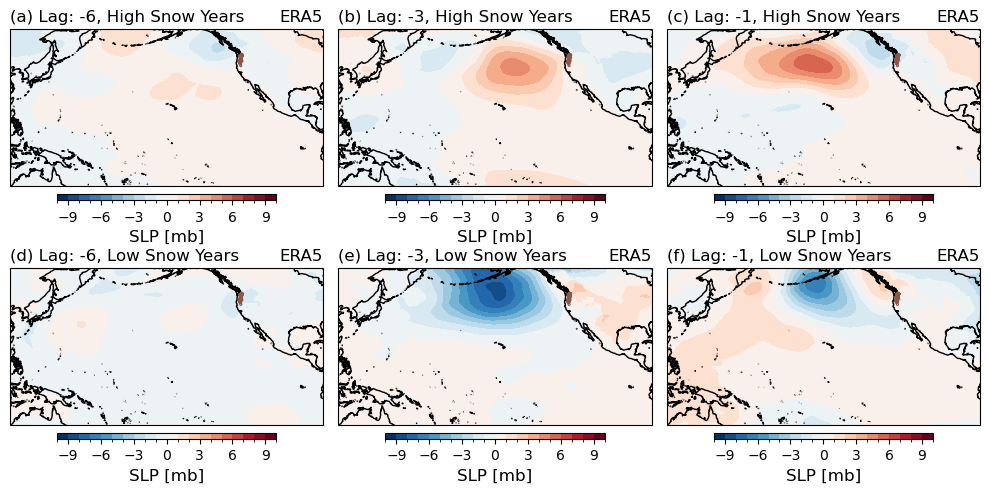

In [56]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_slp = {'shrink':0.7, 'aspect':40,
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-10,10.1,1)

p1 = hsnow_oct.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p1,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)


ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)

ax2.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())
p2 = hsnow_jan.mean(dim='time').plot.contourf(
    ax2=ax2,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p2,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)

ax3.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

p3 = hsnow_mar.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p3,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

cascades_shp.boundary.plot(ax=ax1, color='tab:brown', transform=ccrs.PlateCarree())
cascades_shp.boundary.plot(ax=ax2, color='tab:brown', transform=ccrs.PlateCarree())
cascades_shp.boundary.plot(ax=ax3, color='tab:brown', transform=ccrs.PlateCarree())

ax1.set_title('(a) Lag: -6, High Snow Years', loc='left')
ax2.set_title('(b) Lag: -3, High Snow Years', loc='left')
ax3.set_title('(c) Lag: -1, High Snow Years', loc='left')
ax1.set_title('ERA5', loc='right')
ax2.set_title('ERA5', loc='right')
ax3.set_title('ERA5', loc='right')

ax4 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax4.coastlines(resolution='50m', color='black', linewidth=1)

ax4.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

# cbar_kwargs_slp = {'shrink':0.7, 'aspect':70,
#                'pad':0.04,
#                'orientation':'horizontal'}
# slp_levels = np.arange(-10,10.1,1)

p4 = lsnow_oct.mean(dim='time').plot.contourf(
    ax=ax4,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p4,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

ax5 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax5.coastlines(resolution='50m', color='black', linewidth=1)

ax5.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())
p5 = lsnow_jan.mean(dim='time').plot.contourf(
    ax5=ax5,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p5,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

ax6 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax6.coastlines(resolution='50m', color='black', linewidth=1)

ax6.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

p6 = lsnow_mar.mean(dim='time').plot.contourf(
    ax=ax6,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p6,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

cascades_shp.boundary.plot(ax=ax4, color='tab:brown', transform=ccrs.PlateCarree())
cascades_shp.boundary.plot(ax=ax5, color='tab:brown', transform=ccrs.PlateCarree())
cascades_shp.boundary.plot(ax=ax6, color='tab:brown', transform=ccrs.PlateCarree())

ax4.set_title('(d) Lag: -6, Low Snow Years', loc='left')
ax5.set_title('(e) Lag: -3, Low Snow Years', loc='left')
ax6.set_title('(f) Lag: -1, Low Snow Years', loc='left')
ax4.set_title('ERA5', loc='right')
ax5.set_title('ERA5', loc='right')
ax6.set_title('ERA5', loc='right')

plt.tight_layout()
# plt.savefig(pub_dir+'fig9a_9f.eps',
#             bbox_inches='tight',
#             facecolor='w')

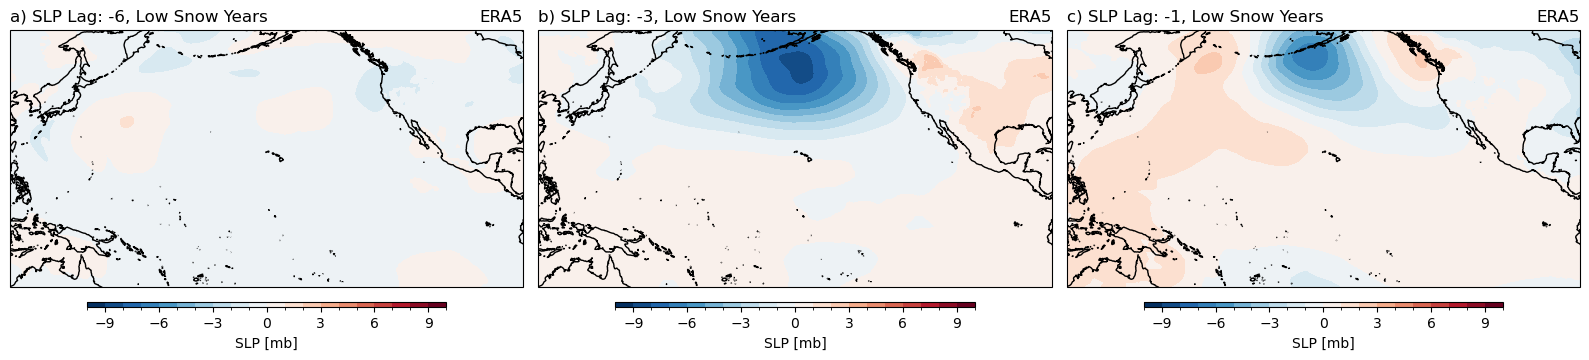

In [240]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(2,3)
ax4 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax4.coastlines(resolution='50m', color='black', linewidth=1)

ax4.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_slp = {'shrink':0.7, 'aspect':70,
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-10,10.1,1)

p1 = lsnow_oct.mean(dim='time').plot.contourf(
    ax=ax4,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p1,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]')


ax5 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax5.coastlines(resolution='50m', color='black', linewidth=1)

ax5.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())
p2 = lsnow_jan.mean(dim='time').plot.contourf(
    ax5=ax5,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p2,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]')

ax6 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax6.coastlines(resolution='50m', color='black', linewidth=1)

ax6.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

p3 = lsnow_mar.mean(dim='time').plot.contourf(
    ax=ax6,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p3,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]')
ax4.set_title('a) SLP Lag: -6, Low Snow Years', loc='left')
ax5.set_title('b) SLP Lag: -3, Low Snow Years', loc='left')
ax6.set_title('c) SLP Lag: -1, Low Snow Years', loc='left')
ax4.set_title('ERA5', loc='right')
ax5.set_title('ERA5', loc='right')
ax6.set_title('ERA5', loc='right')

plt.tight_layout()
plt.savefig('./slp_new_low_snow.png', bbox_inches='tight', facecolor='w', dpi=300)

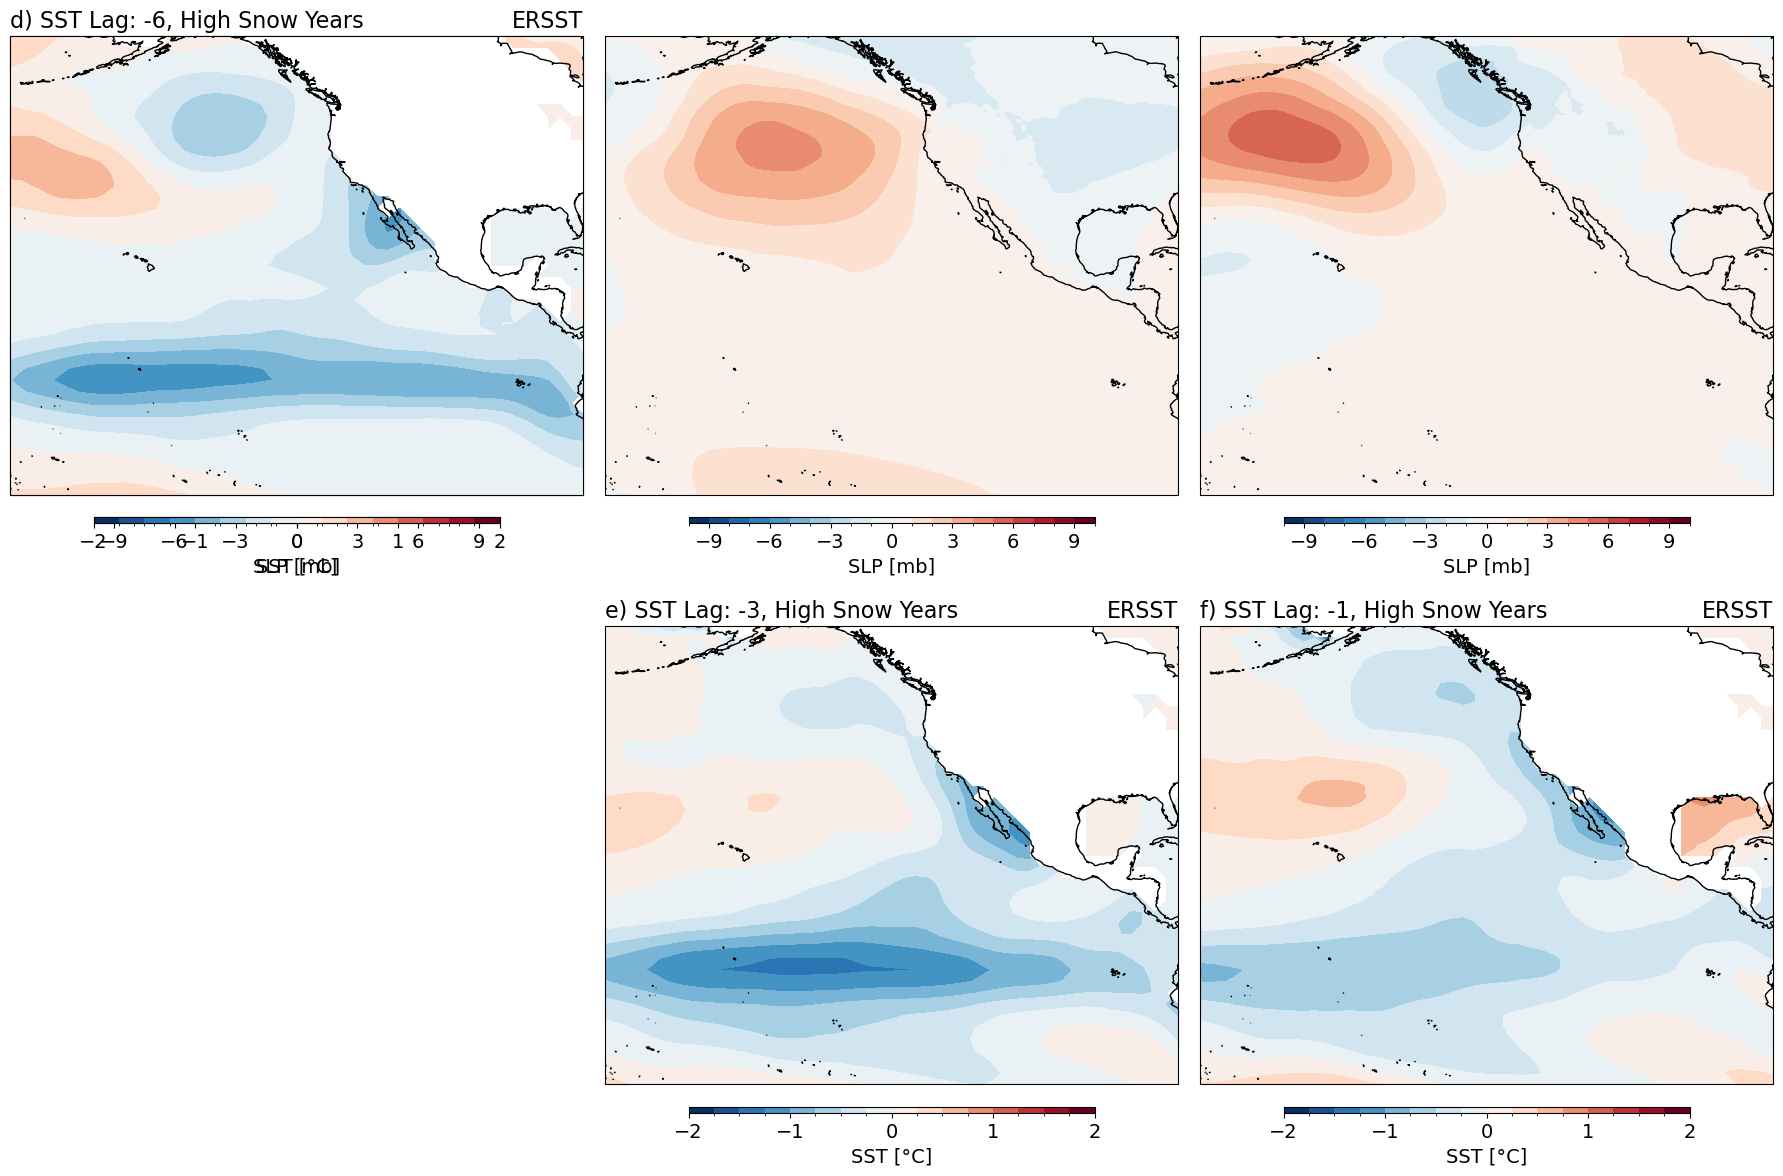

In [273]:
fig = plt.figure(figsize=(18,12))

gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_slp = {'shrink':0.7, 'aspect':70,
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-10,10.1,1)

p1 = hsnow_oct.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p1,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=14)
cb.ax.tick_params(labelsize=14)


ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)

ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())
p2 = hsnow_jan.mean(dim='time').plot.contourf(
    ax2=ax2,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p2,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=14)
cb.ax.tick_params(labelsize=14)

ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)

ax3.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p3 = hsnow_mar.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p3,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=14)
cb.ax.tick_params(labelsize=14)

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_sst = {'shrink':0.7, 'aspect':70,
                   'label':r'SST [°C]',
                   'pad':0.04,
                   'orientation':'horizontal',
                   'ticks':[-2,-1,0,1,2],
                  }
sst_levels = np.arange(-2,2.1,0.25)

p1 = hsnow_oct_sst.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p1,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax2 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p2 = hsnow_jan_sst.mean(dim='time').plot.contourf(
    ax=ax2,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p2,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax3 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)
ax3.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p3 = hsnow_mar_sst.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p3, **cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax1.set_title('a) SLP Lag: -6, High Snow Years', loc='left', fontsize=16)
ax2.set_title('b) SLP Lag: -3, High Snow Years', loc='left', fontsize=16)
ax3.set_title('c) SLP Lag: -1, High Snow Years', loc='left', fontsize=16)
ax1.set_title('ERA5', loc='right', fontsize=16)
ax2.set_title('ERA5', loc='right', fontsize=16)
ax3.set_title('ERA5', loc='right', fontsize=16)


ax1.set_title('d) SST Lag: -6, High Snow Years', loc='left', fontsize=16)
ax2.set_title('e) SST Lag: -3, High Snow Years', loc='left', fontsize=16)
ax3.set_title('f) SST Lag: -1, High Snow Years', loc='left', fontsize=16)
ax1.set_title('ERSST', loc='right', fontsize=16)
ax2.set_title('ERSST', loc='right', fontsize=16)
ax3.set_title('ERSST', loc='right', fontsize=16)

plt.tight_layout()
plt.savefig('./cascades_comp_h_snow.png', facecolor='w', bbox_inches='tight', dpi=300)

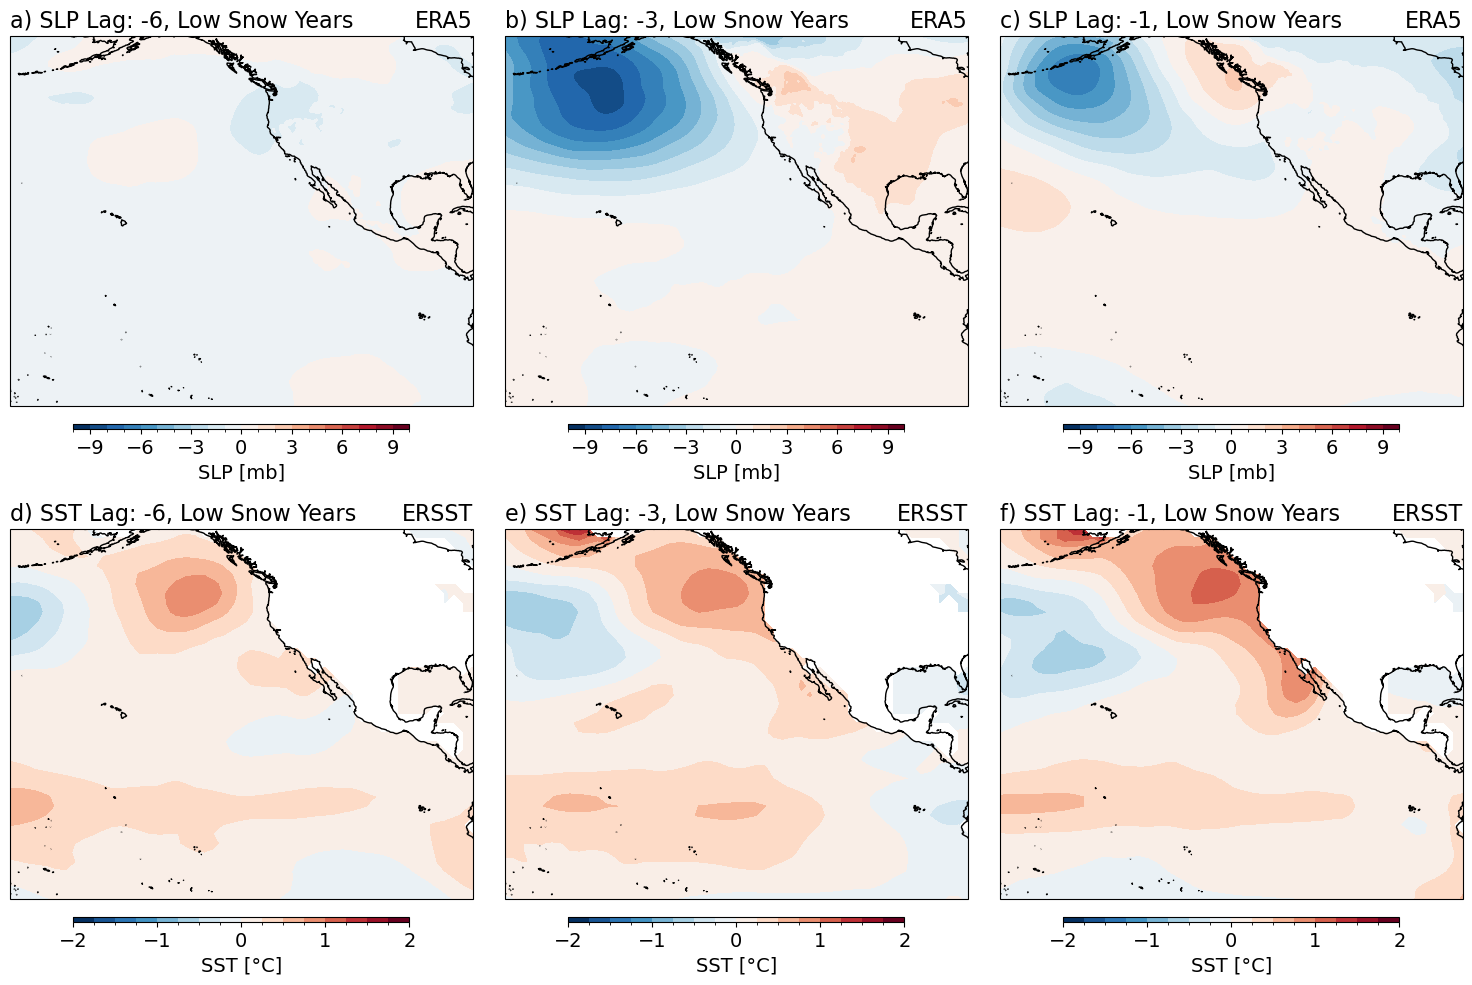

In [256]:
fig = plt.figure(figsize=(15,10))

gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_slp = {'shrink':0.7, 'aspect':70,
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-10,10.1,1)

p1 = lsnow_oct.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p1,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=14)
cb.ax.tick_params(labelsize=14)


ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)

ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())
p2 = lsnow_jan.mean(dim='time').plot.contourf(
    ax2=ax2,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p2,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=14)
cb.ax.tick_params(labelsize=14)

ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)

ax3.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p3 = lsnow_mar.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p3,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=14)
cb.ax.tick_params(labelsize=14)

ax4 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax4.coastlines(resolution='50m', color='black', linewidth=1)

ax4.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_sst = {'shrink':0.7, 'aspect':70,
                   'label':r'SST [°C]',
                   'pad':0.04,
                   'orientation':'horizontal',
                   'ticks':[-2,-1,0,1,2],
                  }
sst_levels = np.arange(-2,2.1,0.25)

p4 = lsnow_oct_sst.mean(dim='time').plot.contourf(
    ax=ax4,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p4,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax5 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax5.coastlines(resolution='50m', color='black', linewidth=1)
ax5.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p5 = lsnow_jan_sst.mean(dim='time').plot.contourf(
    ax=ax5,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p5,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax6 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax6.coastlines(resolution='50m', color='black', linewidth=1)
ax6.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p6 = lsnow_mar_sst.mean(dim='time').plot.contourf(
    ax=ax6,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p6, **cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax1.set_title('a) SLP Lag: -6, Low Snow Years', loc='left', fontsize=16)
ax2.set_title('b) SLP Lag: -3, Low Snow Years', loc='left', fontsize=16)
ax3.set_title('c) SLP Lag: -1, Low Snow Years', loc='left', fontsize=16)
ax1.set_title('ERA5', loc='right', fontsize=16)
ax2.set_title('ERA5', loc='right', fontsize=16)
ax3.set_title('ERA5', loc='right', fontsize=16)


ax4.set_title('d) SST Lag: -6, Low Snow Years', loc='left', fontsize=16)
ax5.set_title('e) SST Lag: -3, Low Snow Years', loc='left', fontsize=16)
ax6.set_title('f) SST Lag: -1, Low Snow Years', loc='left', fontsize=16)
ax4.set_title('ERSST', loc='right', fontsize=16)
ax5.set_title('ERSST', loc='right', fontsize=16)
ax6.set_title('ERSST', loc='right', fontsize=16)

plt.tight_layout()
plt.savefig('./cascades_comp_l_snow.png', facecolor='w', bbox_inches='tight', dpi=300)

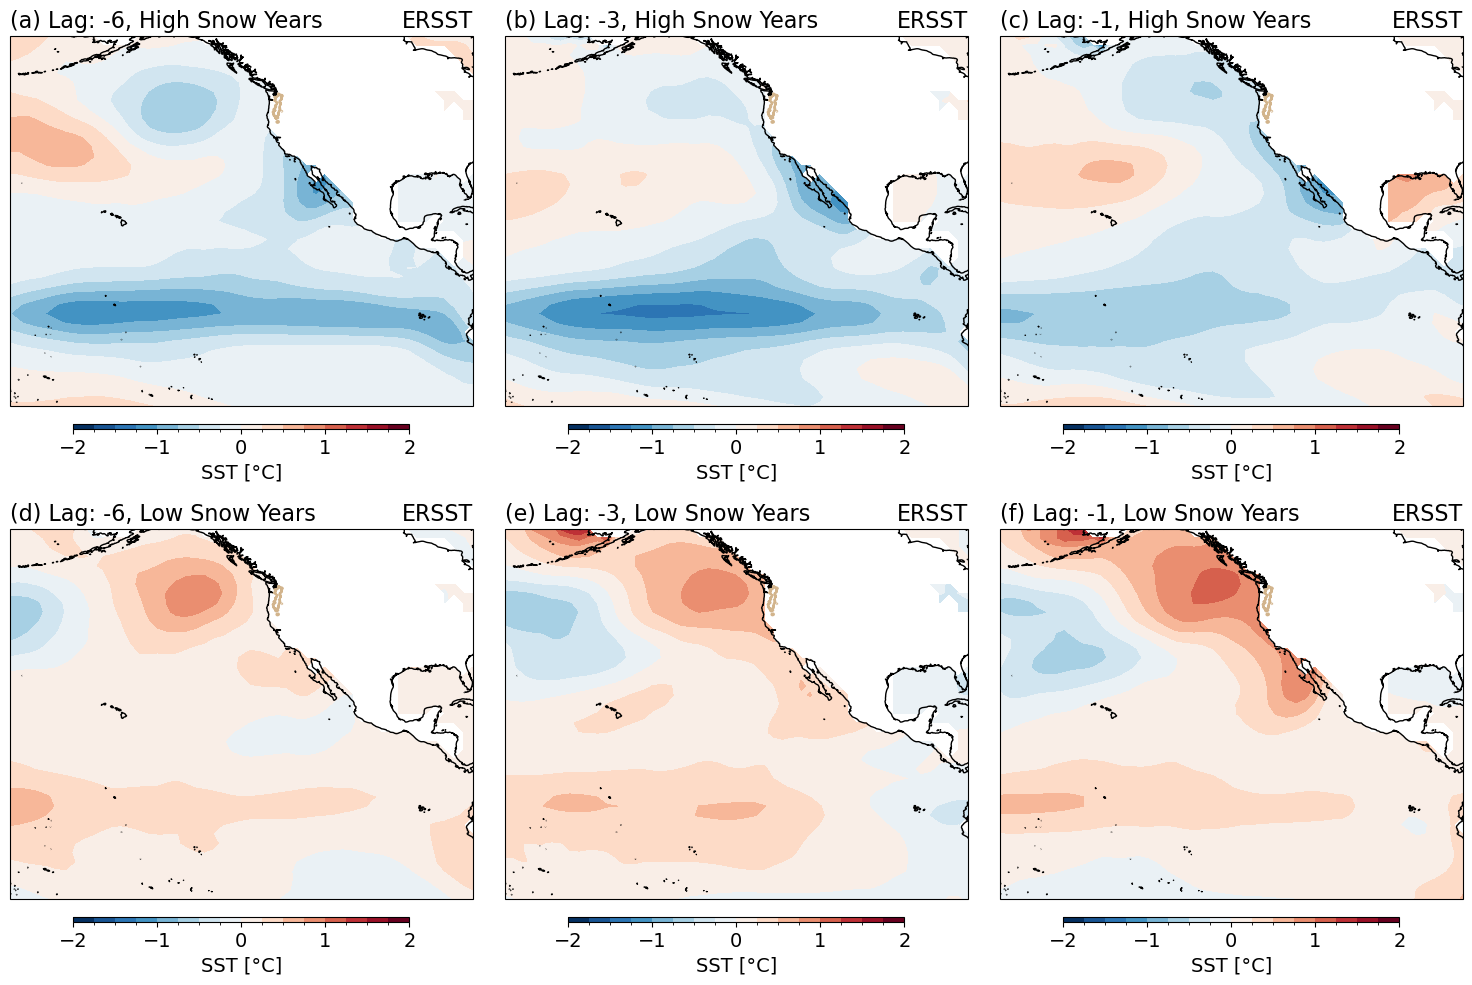

In [51]:
fig = plt.figure(figsize=(15,10))

gs = fig.add_gridspec(2,3)

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_sst = {'shrink':0.7, 'aspect':70,
                   'label':r'SST [°C]',
                   'pad':0.04,
                   'orientation':'horizontal',
                   'ticks':[-2,-1,0,1,2],
                  }
sst_levels = np.arange(-2,2.1,0.25)

p1 = hsnow_oct_sst.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p1,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p2 = hsnow_jan_sst.mean(dim='time').plot.contourf(
    ax=ax2,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p2,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)
ax3.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p3 = hsnow_mar_sst.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p3, **cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

cascades_shp.boundary.plot(ax=ax1, color='tan', transform=ccrs.PlateCarree())
cascades_shp.boundary.plot(ax=ax2, color='tan', transform=ccrs.PlateCarree())
cascades_shp.boundary.plot(ax=ax3, color='tan', transform=ccrs.PlateCarree())

ax4 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax4.coastlines(resolution='50m', color='black', linewidth=1)

ax4.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_sst = {'shrink':0.7, 'aspect':70,
                   'label':r'SST [°C]',
                   'pad':0.04,
                   'orientation':'horizontal',
                   'ticks':[-2,-1,0,1,2],
                  }
sst_levels = np.arange(-2,2.1,0.25)

p4 = lsnow_oct_sst.mean(dim='time').plot.contourf(
    ax=ax4,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p4,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax5 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax5.coastlines(resolution='50m', color='black', linewidth=1)
ax5.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p5 = lsnow_jan_sst.mean(dim='time').plot.contourf(
    ax=ax5,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p5,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax6 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax6.coastlines(resolution='50m', color='black', linewidth=1)
ax6.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p6 = lsnow_mar_sst.mean(dim='time').plot.contourf(
    ax=ax6,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p6, **cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

cascades_shp.boundary.plot(ax=ax4, color='tan', transform=ccrs.PlateCarree())
cascades_shp.boundary.plot(ax=ax5, color='tan', transform=ccrs.PlateCarree())
cascades_shp.boundary.plot(ax=ax6, color='tan', transform=ccrs.PlateCarree())

ax1.set_title('(a) Lag: -6, High Snow Years', loc='left', fontsize=16)
ax2.set_title('(b) Lag: -3, High Snow Years', loc='left', fontsize=16)
ax3.set_title('(c) Lag: -1, High Snow Years', loc='left', fontsize=16)
ax1.set_title('ERSST', loc='right', fontsize=16)
ax2.set_title('ERSST', loc='right', fontsize=16)
ax3.set_title('ERSST', loc='right', fontsize=16)


ax4.set_title('(d) Lag: -6, Low Snow Years', loc='left', fontsize=16)
ax5.set_title('(e) Lag: -3, Low Snow Years', loc='left', fontsize=16)
ax6.set_title('(f) Lag: -1, Low Snow Years', loc='left', fontsize=16)
ax4.set_title('ERSST', loc='right', fontsize=16)
ax5.set_title('ERSST', loc='right', fontsize=16)
ax6.set_title('ERSST', loc='right', fontsize=16)

plt.tight_layout()
# plt.savefig(pub_dir+'fig10a_10f.eps',
#             bbox_inches='tight',
#             facecolor='w')

In [198]:
hsnow_mar = slp_anoms.sel(time=((slp_anoms['time'].dt.month==3) &
                                (slp_anoms['time'].dt.year.isin([1974, 1975, 1976, 1999]))))

hsnow_jan = slp_anoms.sel(time=((slp_anoms['time'].dt.month==1) &
                                (slp_anoms['time'].dt.year.isin([1974, 1975, 1976, 1999]))))

hsnow_oct = slp_anoms.sel(time=((slp_anoms['time'].dt.month==10) &
                                (slp_anoms['time'].dt.year.isin([1973, 1974, 1975, 1998]))))

In [199]:
lsnow_mar = slp_anoms.sel(time=((slp_anoms['time'].dt.month==3) &
                                (slp_anoms['time'].dt.year.isin([1981, 2001, 2005, 2015]))))

lsnow_jan = slp_anoms.sel(time=((slp_anoms['time'].dt.month==1) &
                                (slp_anoms['time'].dt.year.isin([1981, 2001, 2005, 2015]))))

lsnow_oct = slp_anoms.sel(time=((slp_anoms['time'].dt.month==10) &
                                (slp_anoms['time'].dt.year.isin([1980, 2000, 2004, 2014]))))

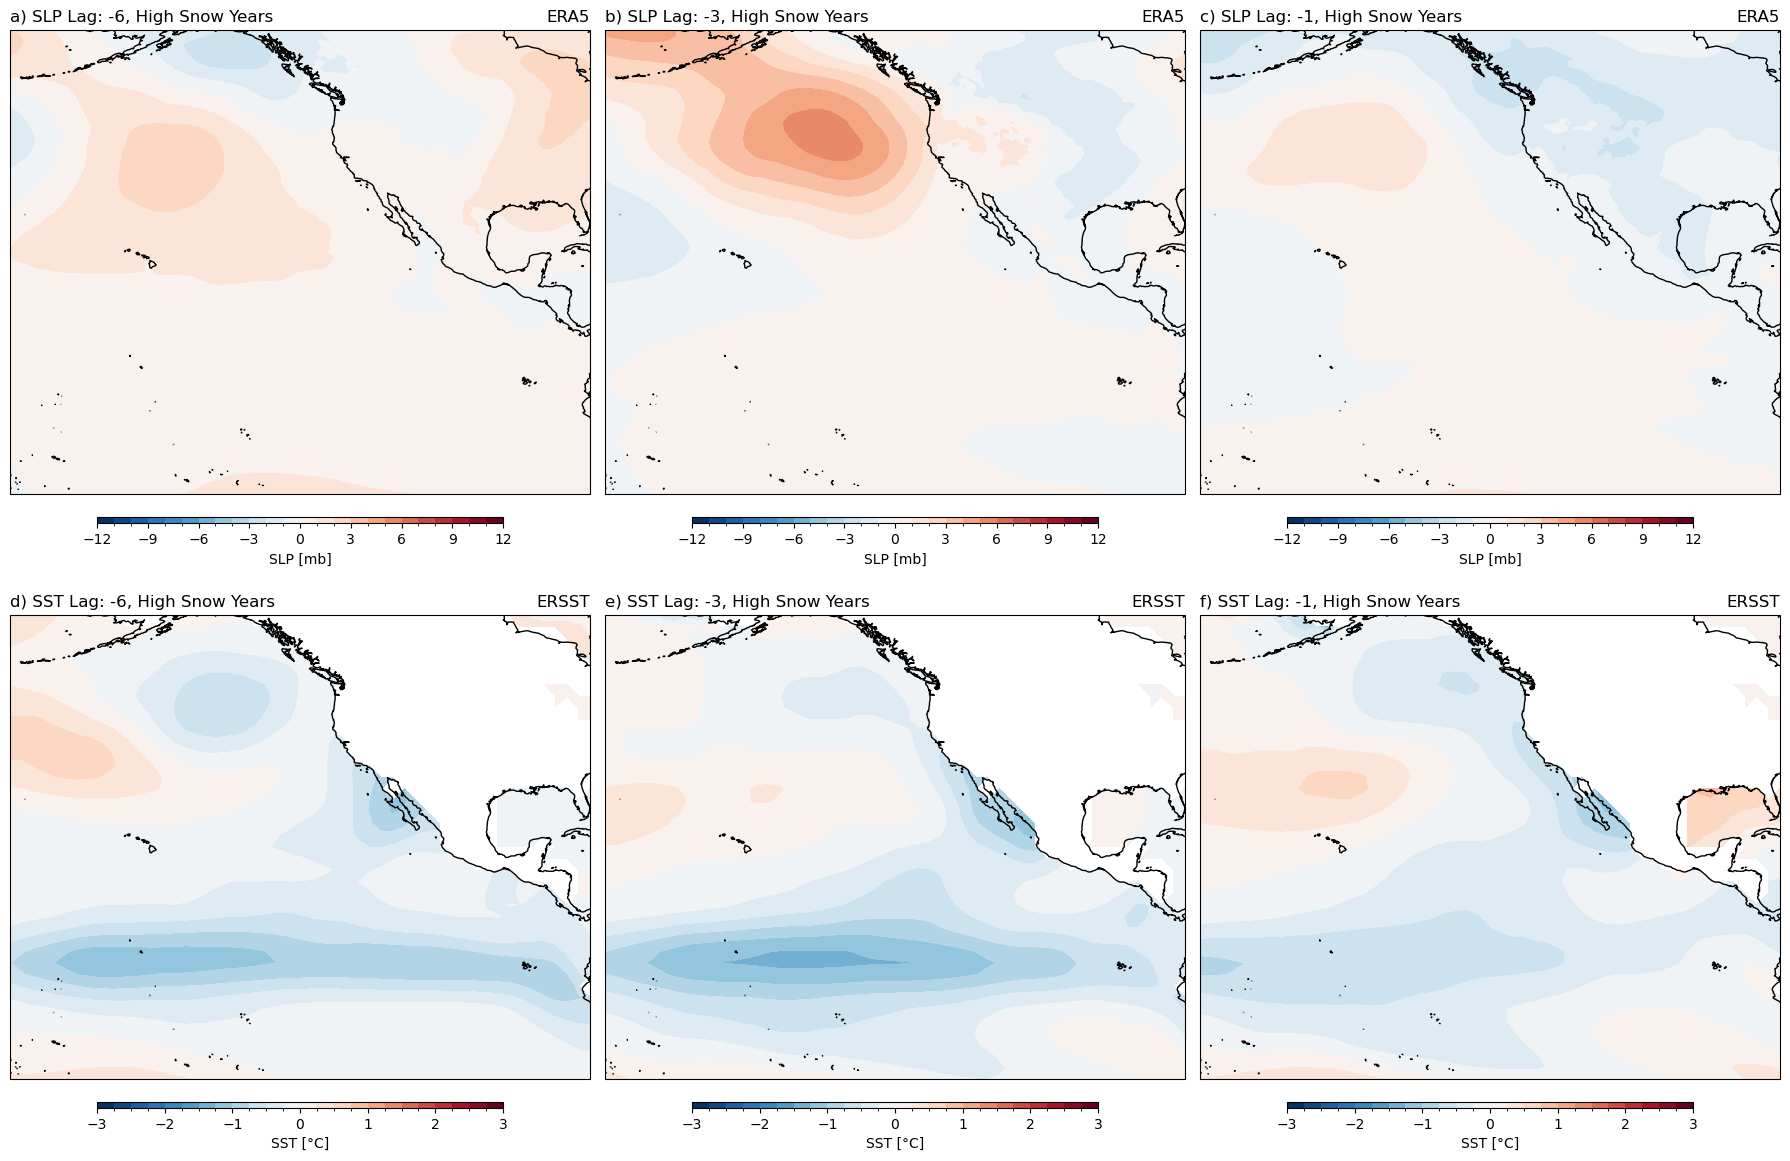

In [201]:
fig = plt.figure(figsize=(18,12))

gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_slp = {'shrink':0.7, 'aspect':70,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-12,12.1,1)
hsnow_oct.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_slp)

# winds.sel(time='2015-03-01', pressure_level=850.0).plot.streamplot(ax=ax,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())


ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)

ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())
hsnow_jan.mean(dim='time').plot.contourf(
    ax2=ax2,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_slp)


ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)

ax3.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

hsnow_mar.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_slp)

ax4 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax4.coastlines(resolution='50m', color='black', linewidth=1)

ax4.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_sst = {'shrink':0.7, 'aspect':70,
               'label':r'SST [°C]',
               'pad':0.04,
               'orientation':'horizontal',
                  'ticks':[-3,-2,-1,0,1,2,3]}
sst_levels = np.arange(-3,3.1,0.25)

hsnow_oct_sst.mean(dim='time').plot.contourf(
    ax=ax4,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_sst)

ax5 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax5.coastlines(resolution='50m', color='black', linewidth=1)
ax5.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

hsnow_jan_sst.mean(dim='time').plot.contourf(
    ax=ax5,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_sst)

ax6 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax6.coastlines(resolution='50m', color='black', linewidth=1)
ax6.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

hsnow_mar_sst.mean(dim='time').plot.contourf(
    ax=ax6,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_sst)

ax1.set_title('a) SLP Lag: -6, High Snow Years', loc='left')
ax2.set_title('b) SLP Lag: -3, High Snow Years', loc='left')
ax3.set_title('c) SLP Lag: -1, High Snow Years', loc='left')
ax1.set_title('ERA5', loc='right')
ax2.set_title('ERA5', loc='right')
ax3.set_title('ERA5', loc='right')


ax4.set_title('d) SST Lag: -6, High Snow Years', loc='left')
ax5.set_title('e) SST Lag: -3, High Snow Years', loc='left')
ax6.set_title('f) SST Lag: -1, High Snow Years', loc='left')
ax4.set_title('ERSST', loc='right')
ax5.set_title('ERSST', loc='right')
ax6.set_title('ERSST', loc='right')
plt.tight_layout()

# plt.savefig('./cascades_comp_h_snow.png', facecolor='w', bbox_inches='tight', dpi=300)

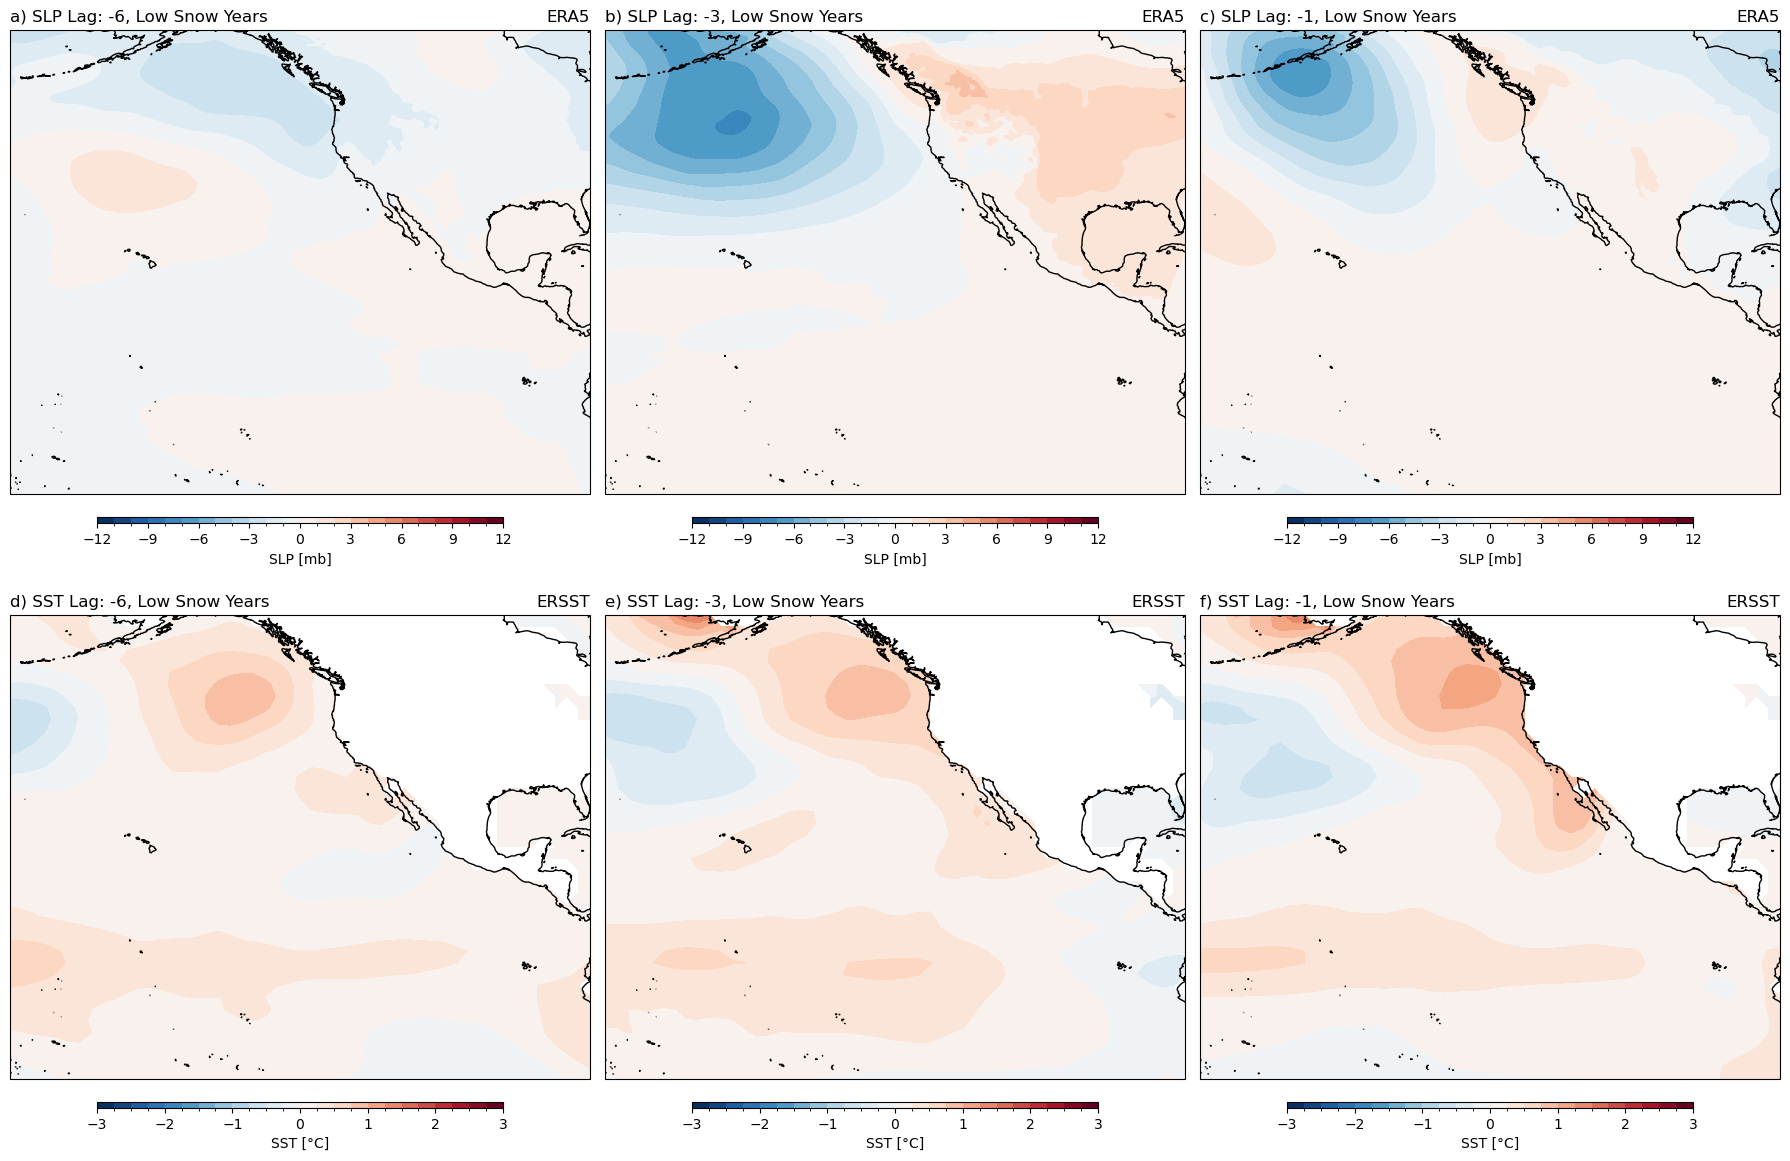

In [202]:
fig = plt.figure(figsize=(18,12))

gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_slp = {'shrink':0.7, 'aspect':70,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-12,12.1,1)

lsnow_oct.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_slp)

# winds.sel(time='2015-03-01', pressure_level=850.0).plot.streamplot(ax=ax,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())


ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)

ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())
lsnow_jan.mean(dim='time').plot.contourf(
    ax2=ax2,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_slp)


ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)

ax3.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

lsnow_mar.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_slp)

ax4 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax4.coastlines(resolution='50m', color='black', linewidth=1)

ax4.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_sst = {'shrink':0.7, 'aspect':70,
               'label':r'SST [°C]',
               'pad':0.04,
               'orientation':'horizontal',
                  'ticks':[-3,-2,-1,0,1,2,3]}
sst_levels = np.arange(-3,3.1,0.25)

lsnow_oct_sst.mean(dim='time').plot.contourf(
    ax=ax4,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_sst)

ax5 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax5.coastlines(resolution='50m', color='black', linewidth=1)
ax5.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

lsnow_jan_sst.mean(dim='time').plot.contourf(
    ax=ax5,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_sst)

ax6 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax6.coastlines(resolution='50m', color='black', linewidth=1)
ax6.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

lsnow_mar_sst.mean(dim='time').plot.contourf(
    ax=ax6,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs_sst)

ax1.set_title('a) SLP Lag: -6, Low Snow Years', loc='left')
ax2.set_title('b) SLP Lag: -3, Low Snow Years', loc='left')
ax3.set_title('c) SLP Lag: -1, Low Snow Years', loc='left')
ax1.set_title('ERA5', loc='right')
ax2.set_title('ERA5', loc='right')
ax3.set_title('ERA5', loc='right')


ax4.set_title('d) SST Lag: -6, Low Snow Years', loc='left')
ax5.set_title('e) SST Lag: -3, Low Snow Years', loc='left')
ax6.set_title('f) SST Lag: -1, Low Snow Years', loc='left')
ax4.set_title('ERSST', loc='right')
ax5.set_title('ERSST', loc='right')
ax6.set_title('ERSST', loc='right')

plt.tight_layout()
# plt.savefig('./cascades_comp_l_snow.png', facecolor='w', bbox_inches='tight', dpi=300)

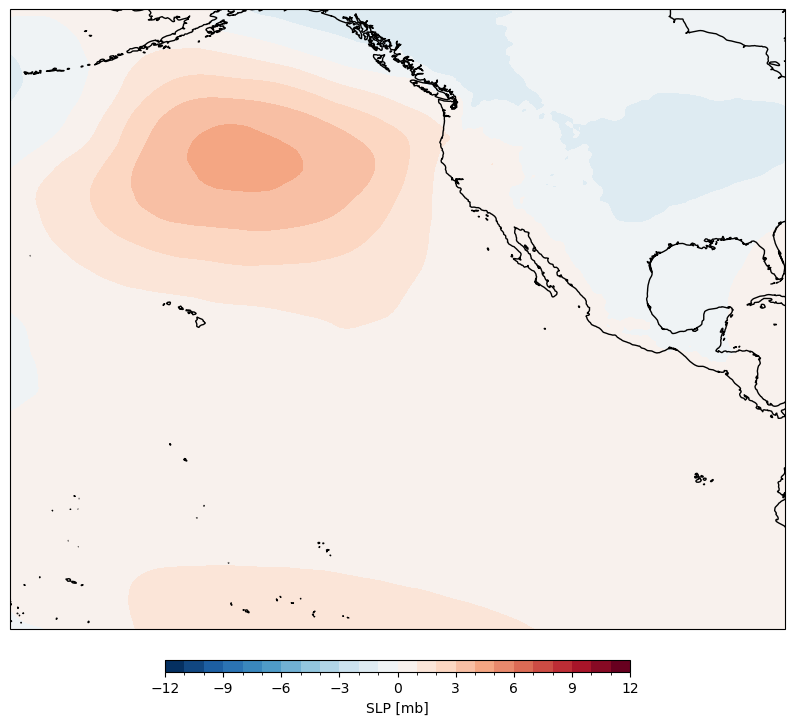

In [86]:
plt.figure(figsize=(10,10))
ax2 = plt.ax2es(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)

ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-12,12.1,1)
hsnow_jan.mean(dim='time').plot.contourf(
    ax2=ax2,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

# winds.sel(time='2015-03-01', pressure_level=850.0).plot.streamplot(ax2=ax2,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())

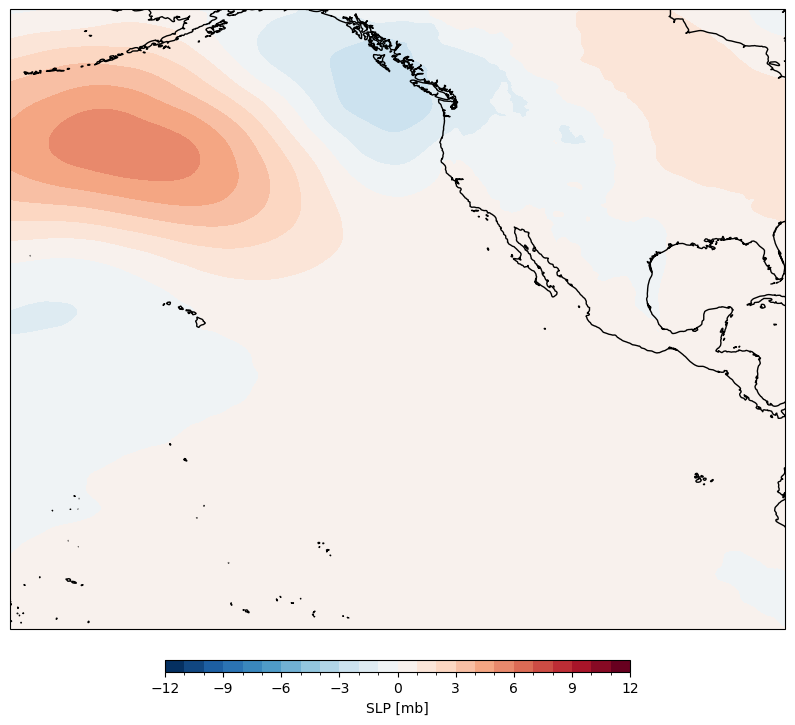

In [80]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-12,12.1,1)
hsnow_mar.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

# winds.sel(time='2015-03-01', pressure_level=850.0).plot.streamplot(ax=ax,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())

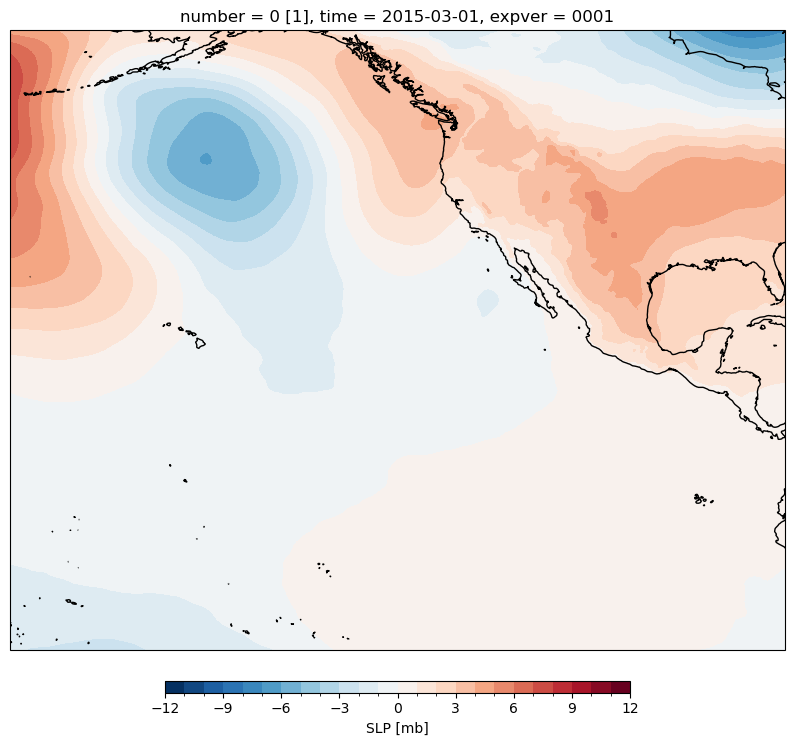

In [41]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-12,12.1,1)
slp_anoms.sel(time='2015-03-01').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

# winds.sel(time='2015-03-01', pressure_level=850.0).plot.streamplot(ax=ax,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())

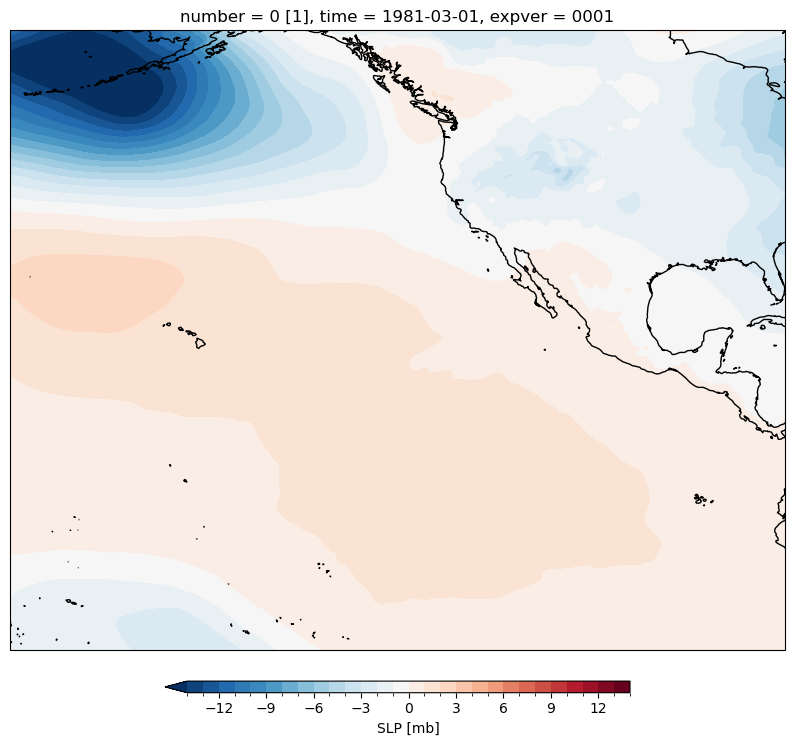

In [22]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-14,14.1,1)
slp_anoms.sel(time='1981-03-01').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

# winds.sel(time='1992-03-01', pressure_level=850.0).plot.streamplot(ax=ax,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())

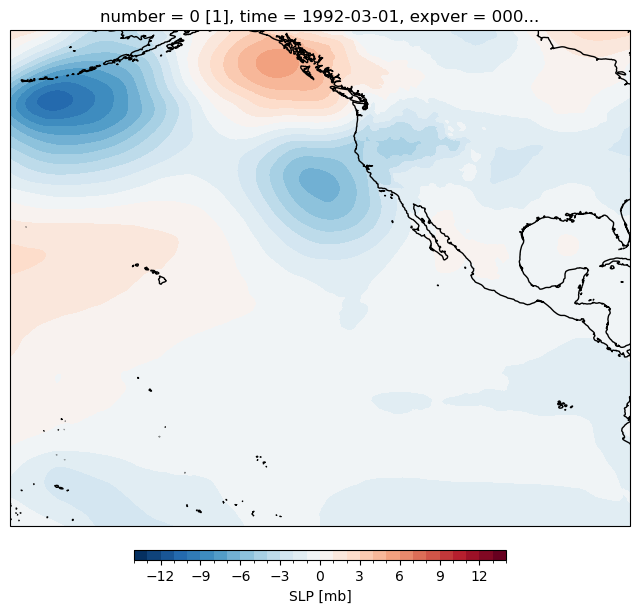

In [139]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-14,14.1,1)
slp_anoms.sel(time='1992-03-01').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

# winds.sel(time='1992-03-01', pressure_level=850.0).plot.streamplot(ax=ax,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())

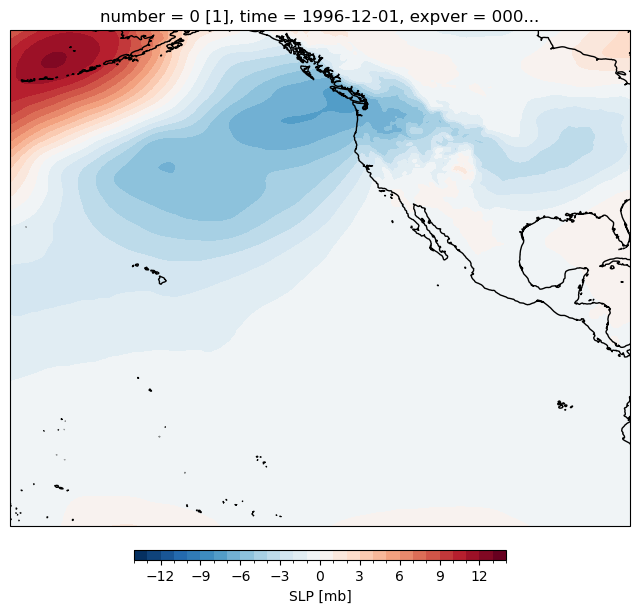

In [148]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-14,14.1,1)
slp_anoms.sel(time='1996-12-01').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

# winds.sel(time='1992-03-01', pressure_level=850.0).plot.streamplot(ax=ax,
#                                 x='longitude',
#                                 y='latitude',
#                                 u='u',
#                                 v='v', transform=ccrs.PlateCarree())

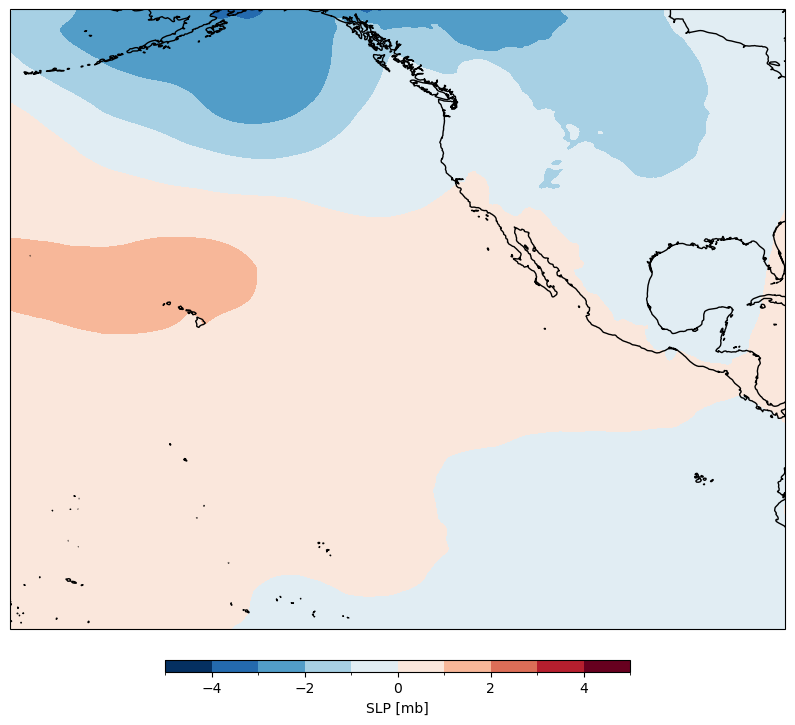

In [38]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-5,5.1,1)
h_snow_djf.mean(dim='time').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

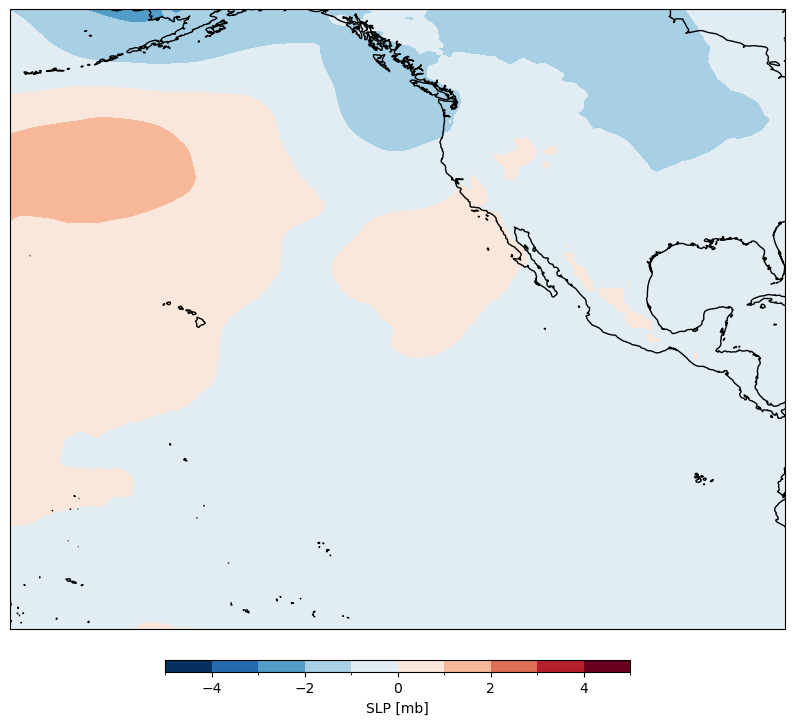

In [40]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-5,5.1,1)
l_snow_djf.mean(dim='time').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

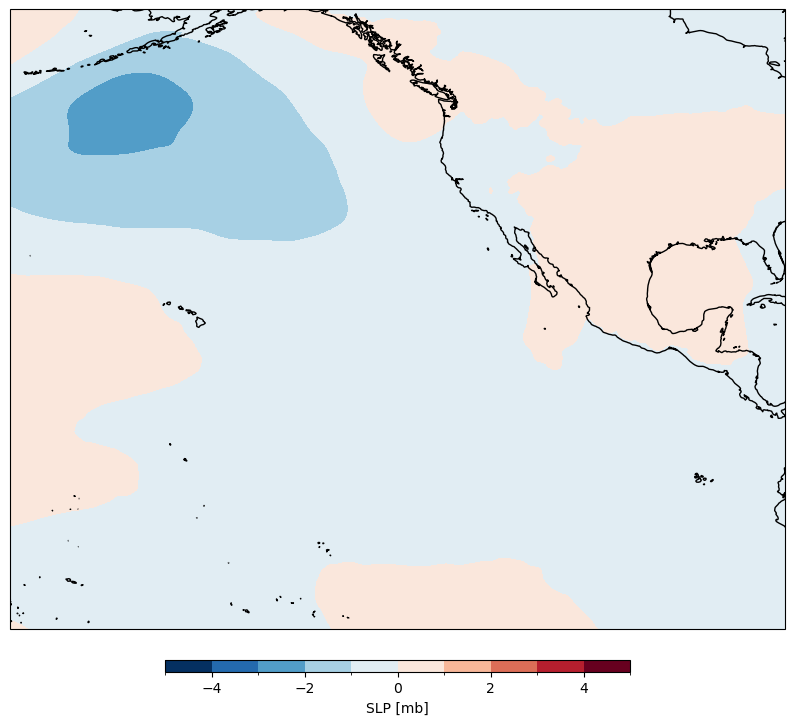

In [43]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-5,5.1,1)
h_snow_mam.mean(dim='time').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

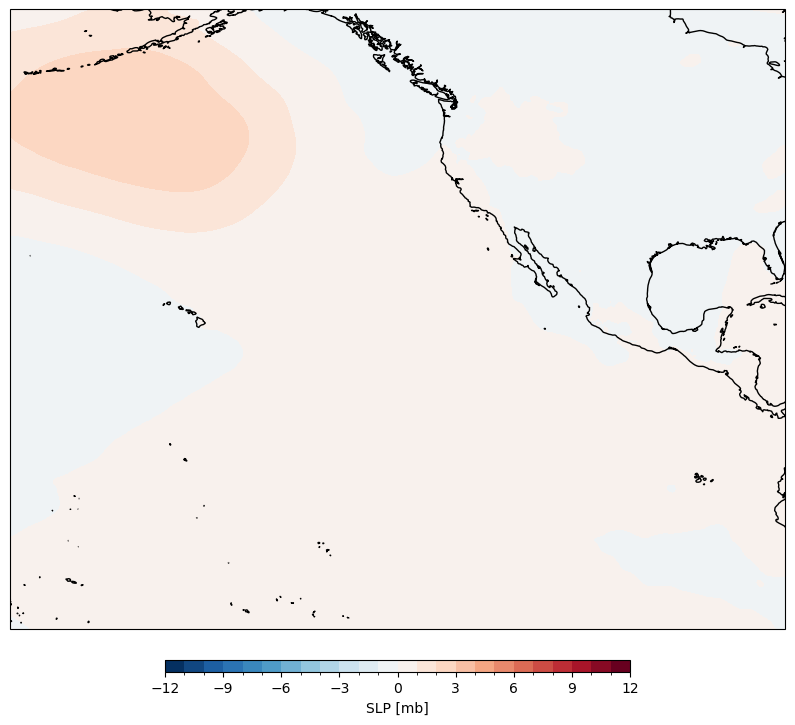

In [44]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-12,12.1,1)
l_snow_mam.mean(dim='time').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

In [27]:
diff_djf = h_snow_djf.mean(dim='time') - l_snow_djf.mean(dim='time')
diff_mam = h_snow_mam.mean(dim='time') - l_snow_mam.mean(dim='time')

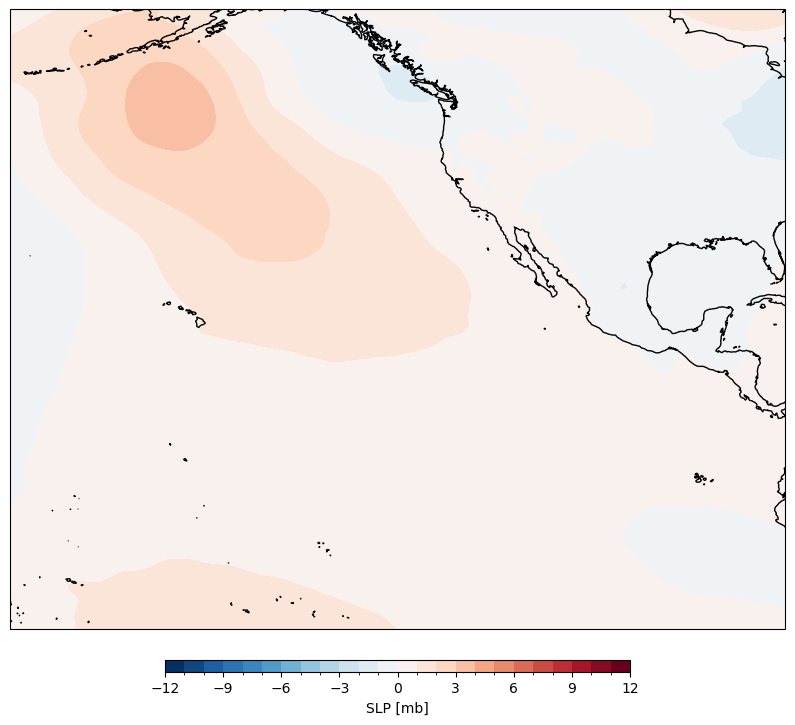

In [28]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-12,12.1,1)
diff_djf.plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

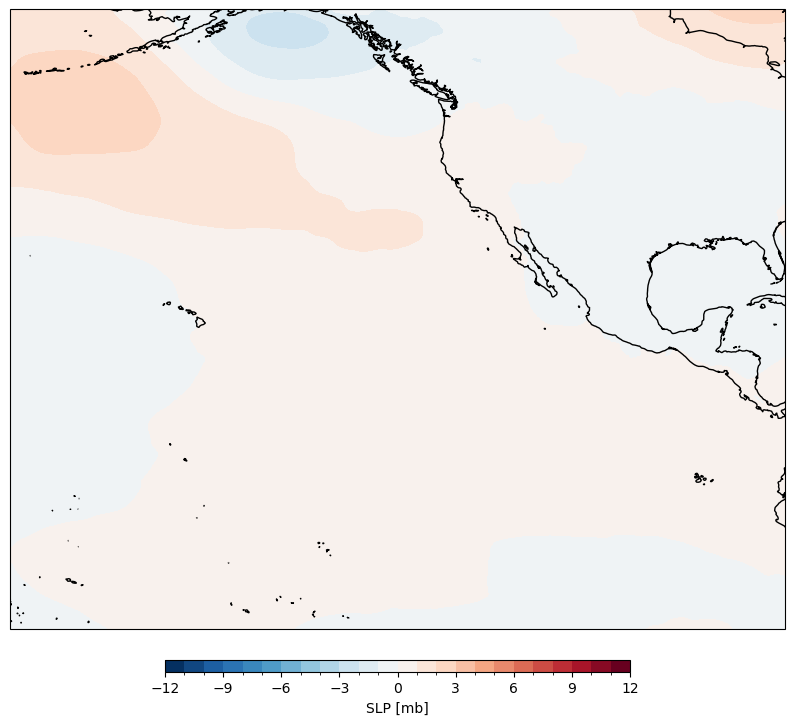

In [29]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-12,12.1,1)
diff_mam.plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

In [30]:
h_snow_djf_pdo_w = slp_anoms_djf.sel(time=slp_anoms_djf['time'].dt.year.isin([1984, 1994, 1996]))
h_snow_djf_pdo_c = slp_anoms_djf.sel(time=slp_anoms_djf['time'].dt.year.isin([1998, 2006, 2010]))

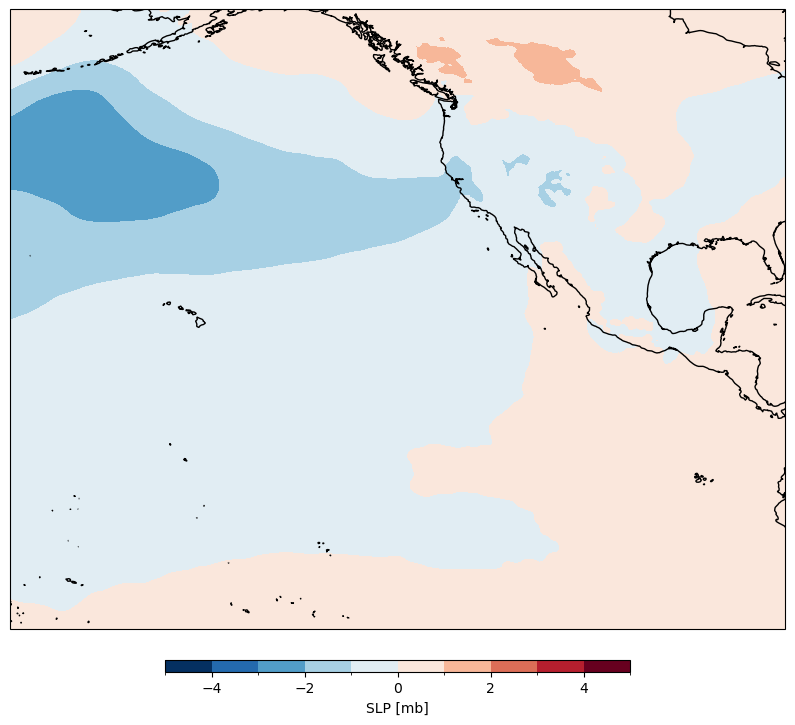

In [31]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-5,5.1,1)
h_snow_djf_pdo_w.mean(dim='time').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

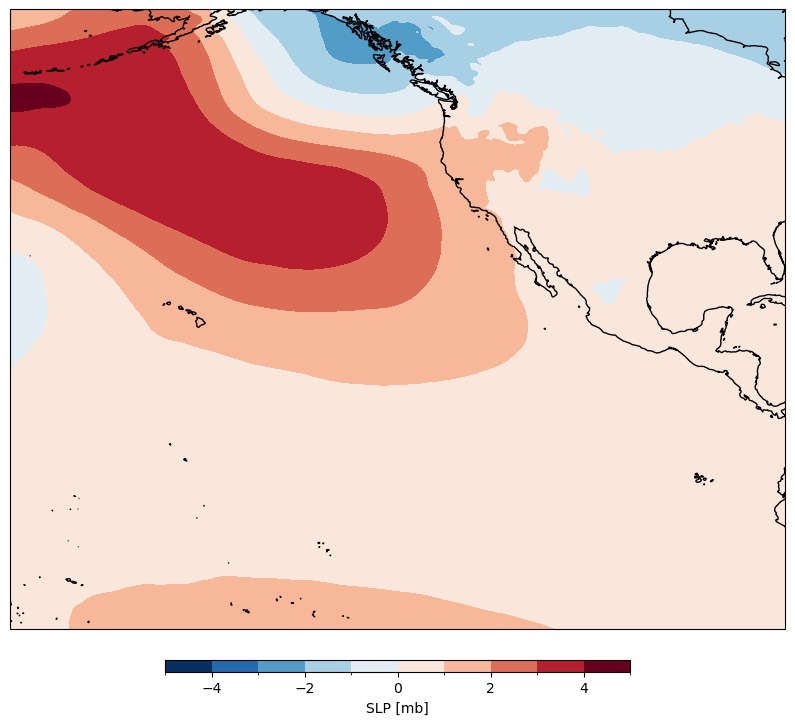

In [32]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-5,5.1,1)
h_snow_djf_pdo_c.mean(dim='time').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

In [33]:
l_snow_djf_pdo_w = slp_anoms_djf.sel(time=slp_anoms_djf['time'].dt.year.isin([1980, 1989, 1991]))
l_snow_djf_pdo_c = slp_anoms_djf.sel(time=slp_anoms_djf['time'].dt.year.isin([2004, 2013, 2014]))

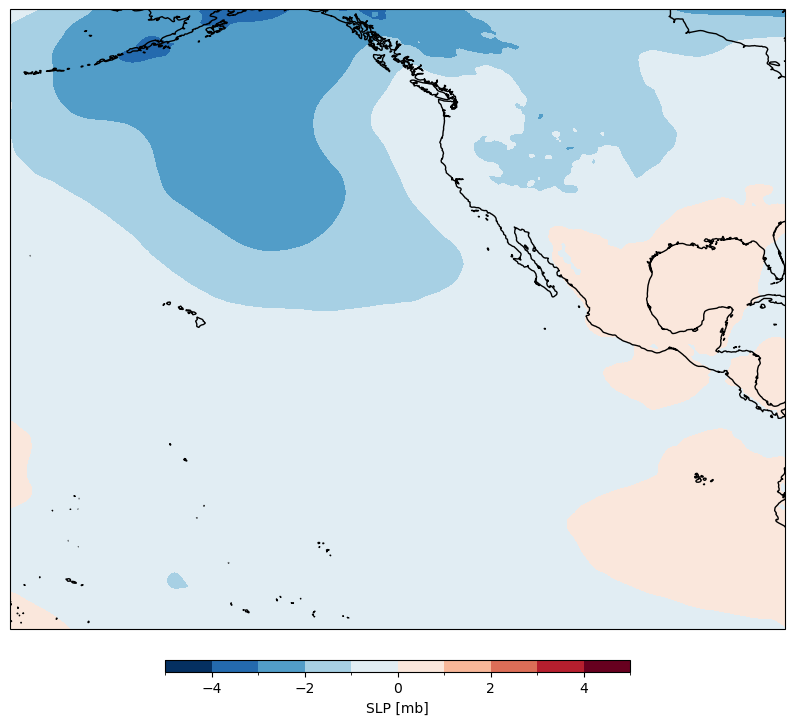

In [34]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-5,5.1,1)
l_snow_djf_pdo_w.mean(dim='time').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)

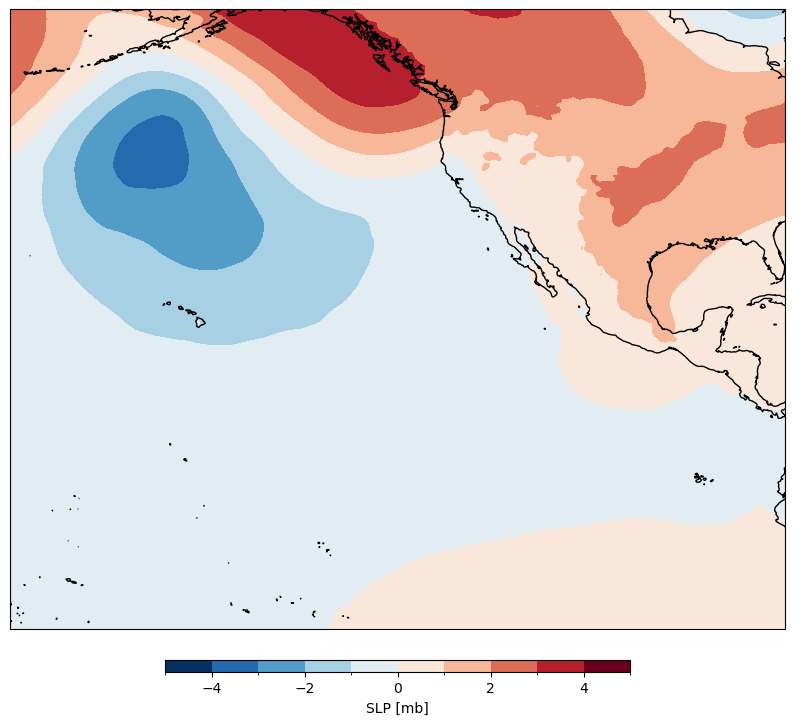

In [35]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-5,5.1,1)
l_snow_djf_pdo_c.mean(dim='time').plot.contourf(
    ax=ax,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs)